In [12]:
%load_ext autoreload
%autoreload 2

import qubx

%qubxd

import numpy as np
import pandas as pd
import asyncio
import ccxt.pro

import gzip
import json
import copy

import matplotlib.pyplot as plt

from pathlib import Path
from qubx import lookup
from qubx.connectors.ccxt.ccxt_utils import ccxt_convert_orderbook


output_path = Path("/mnt/HC_Volume_100695026/home/shared/devs/Qubx/tests/data/BTCUSDT_ccxt_orderbooks.txt.gz")
# output_path = Path("/mnt/HC_Volume_100695026/home/shared/devs/Qubx/tests/data/XRPUSDT_ccxt_orderbooks.txt.gz")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Collect live orderbooks

In [ ]:
# ob = await exchange.watch_order_book_for_symbols([
#     "BTCUSDT",
#     # "XRPUSDT", "ETHUSDT", "XRPUSDT", "LTCUSDT", "BCHUSDT", "EOSUSDT", "BNBUSDT", "TRXUSDT", "ADAUSDT", "XLMUSDT",
#     # "LINKUSDT", "XTZUSDT", "XMRUSDT", "DASHUSDT", "ZECUSDT", "ETCUSDT", "VETUSDT", "QTUMUSDT", "IOTAUSDT", "THETAUSDT",
#     # "ATOMUSDT", "ALGOUSDT", "ZILUSDT", "KNCUSDT", "OMGUSDT", "DOGEUSDT", "COMPUSDT", "SUSHIUSDT", "YFIUSDT", "UNIUSDT",
# ], limit=100)

exchange = ccxt.pro.binanceusdm({
    "options": {
        "watchOrderBookRate": 100,
    },
    "asyncio_loop": asyncio.get_event_loop(),
})

symbol = 'BTCUSDT'
orderbooks = []

try:
    while True:
        ob = await exchange.watch_order_book("BTCUSDT")
        orderbooks.append(copy.deepcopy(ob))
        if len(orderbooks) % 100 == 0:
            print(len(orderbooks), 'order books fetched')
except KeyboardInterrupt:
    print("Interrupted")
except Exception as e:
    print(type(e).__name__, str(e))
finally:
    await exchange.close()

In [14]:
len(orderbooks)

216

In [15]:
orderbooks[0]

{'bids': [[72684.9, 7.517], [72684.8, 0.004], [72684.2, 0.066], [72684.1, 0.219], [72684.0, 0.002], [72683.7, 0.002], [72683.5, 0.002], [72683.4, 0.002], [72683.0, 0.006], [72682.8, 0.013], [72682.7, 0.004], [72682.0, 0.004], [72681.7, 0.017], [72681.0, 0.114], [72680.6, 0.029], [72680.3, 0.292], [72680.0, 0.002], [72679.9, 0.002], [72679.8, 0.002], [72679.5, 0.014], [72679.4, 0.002], [72679.1, 0.006], [72679.0, 0.002], [72678.9, 0.137], [72678.8, 0.144], [72678.7, 0.317], [72678.4, 0.121], [72678.3, 0.171], [72678.1, 0.012], [72678.0, 0.002], [72677.9, 0.002], [72677.8, 0.002], [72677.7, 0.002], [72677.6, 0.012], [72677.5, 0.167], [72677.4, 0.005], [72677.3, 0.443], [72677.1, 0.004], [72677.0, 0.46], [72676.9, 0.002], [72676.6, 0.004], [72676.5, 0.002], [72676.3, 0.196], [72676.2, 0.014], [72676.0, 0.002], [72675.9, 0.144], [72675.8, 0.002], [72675.7, 0.006], [72675.6, 0.002], [72675.5, 0.017], [72675.4, 0.005], [72675.3, 0.002], [72675.2, 0.002], [72675.1, 0.311], [72675.0, 0.112], [

In [16]:
orderbooks[10]

{'bids': [[72684.9, 3.441], [72684.8, 0.002], [72684.2, 0.002], [72684.1, 0.219], [72684.0, 0.002], [72683.7, 0.002], [72683.5, 0.002], [72683.4, 0.002], [72683.0, 0.006], [72682.8, 0.013], [72682.7, 0.004], [72682.0, 0.004], [72681.7, 0.017], [72681.0, 0.004], [72680.6, 0.029], [72680.3, 0.19], [72680.0, 0.002], [72679.9, 0.002], [72679.8, 0.002], [72679.5, 0.014], [72679.4, 0.002], [72679.1, 0.006], [72679.0, 0.002], [72678.8, 0.002], [72678.7, 0.317], [72678.4, 0.066], [72678.3, 0.171], [72678.1, 0.012], [72678.0, 0.002], [72677.8, 0.002], [72677.7, 0.002], [72677.6, 0.012], [72677.5, 0.167], [72677.4, 0.002], [72677.3, 0.443], [72677.1, 0.002], [72677.0, 0.46], [72676.9, 0.002], [72676.8, 0.002], [72676.6, 0.004], [72676.5, 0.002], [72676.3, 0.19], [72676.2, 0.012], [72676.1, 0.002], [72676.0, 0.002], [72675.9, 0.144], [72675.8, 0.008], [72675.6, 0.002], [72675.5, 0.017], [72675.4, 0.005], [72675.3, 0.002], [72675.2, 0.002], [72675.1, 0.309], [72675.0, 0.112], [72674.7, 0.08], [726

Here is a just a check that I used for debugging how ccxt handles connections if we watch separately each symbol.

A new connection is created for each symbol as opposed to the previous case.

In [ ]:
exchange = ccxt.pro.binanceusdm({
    "options": {
        "watchOrderBookRate": 100,
    },
    "asyncio_loop": asyncio.get_event_loop(),
})

symbols = [
    "BTCUSDT", "ETHUSDT", "XRPUSDT"
    # "LTCUSDT", "BCHUSDT", "EOSUSDT", "BNBUSDT", "TRXUSDT", "ADAUSDT", "XLMUSDT",
    # "LINKUSDT", "XTZUSDT", "XMRUSDT", "DASHUSDT", "ZECUSDT", "ETCUSDT", "VETUSDT", "QTUMUSDT", "IOTAUSDT", "THETAUSDT",
    # "ATOMUSDT", "ALGOUSDT", "ZILUSDT", "KNCUSDT", "OMGUSDT", "DOGEUSDT", "COMPUSDT", "SUSHIUSDT", "YFIUSDT", "UNIUSDT",
]

orderbooks = []

async def fetch_order_book(symbol):
    while True:
        orderbooks.append((await exchange.watch_order_book(symbol, limit=1000)).copy())
        if len(orderbooks) % 1000 == 0:
            print(f"{symbol}: {len(orderbooks)} order books fetched")

tasks = [fetch_order_book(symbol) for symbol in symbols]

try:
    await asyncio.gather(*tasks)
except KeyboardInterrupt:
    print(f"{symbol}: Interrupted")
except Exception as e:
    print(f"{symbol}: {type(e).__name__} {str(e)}")
finally:
    await exchange.close()


Save the first 1000 snapshots into a txt.gz file. I decided to go for a raw file because it is easier to view the data in an editor and the json objects remain untouched.

In [17]:
with gzip.open(output_path, 'wt', encoding='utf-8') as f:
    for orderbook in orderbooks[:1000]:
        f.write(json.dumps(orderbook) + '\n')

## 2. Read orderbooks and transform to internal format

In [8]:
with gzip.open(output_path, "rt") as f:
    orderbooks = [json.loads(line) for line in f]

In [11]:
i1 = lookup.find_symbol("BINANCE.UM", "BTCUSDT")
assert i1 is not None

obs = [
    ccxt_convert_orderbook(orderbook, i1)
    for orderbook in orderbooks
]

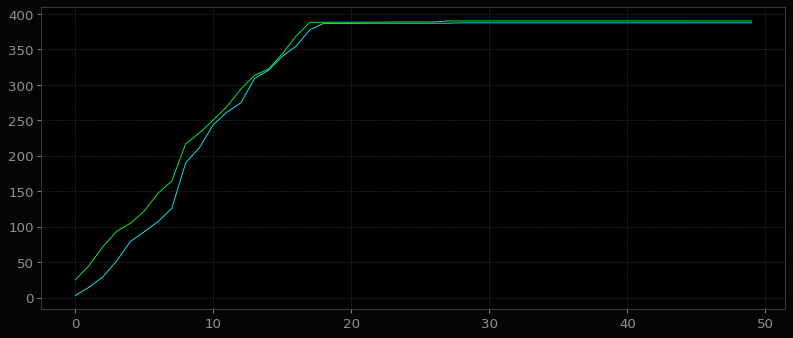

In [23]:
plt.plot(obs[100].asks.cumsum())
plt.plot(obs[100].bids.cumsum())